# APPLICATION OF APACHE SPARK AND RNN IN BANANA PRICE FORECASTING

## STOP ANY ACTIVE SPARK SESSION

In [1]:
from pyspark.sql import SparkSession

# Stop all active Spark sessions
SparkSession.builder.getOrCreate().stop()


## Import all the necessary libraries required for loading the data, EDA, Data Cleaning and statistics

In [2]:
import warnings
warnings.filterwarnings("ignore")
from pyspark.ml import Pipeline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#List the contents of the root directory in HDFS
!hdfs dfs -ls /

Found 4 items
-rwxrwxrwx   1 hduser supergroup    1114475 2024-03-31 17:22 /CPM04.20240331170654.csv
-rwxrwxrwx   1 hduser supergroup    1197604 2024-03-31 17:23 /CPM12.20240331170619.csv
drwxr-xr-x   - hduser supergroup          0 2024-01-30 23:49 /output1
drwxr-xr-x   - hduser supergroup          0 2024-01-31 00:57 /user1


## Preprocessing Data using Spark
This process involves a series of steps. They include:-
1. Loading 2 CSV files on national average prices of food data stored in hadoop.

2. Data Exploration: Perform exploratory data analysis (EDA) 
- This include- checking missing data, duplicates, oultiers, data types, visualize data to see data pattern
3. Data cleaning and preparation: Data integration, merging the two csv datasets, handling duplicates, missing data, outliers, feature selection, changing data types
4. Feature engineering, encoding data, splitting data into training and test set, normalizing/standardizing the data
5. Training LSTM-RNN model, testing the model, hyper parameter tuning then deploying the model/making a prediciton

4. Data Export: Export the preprocessed data to hadoop for storage

## Initialize Spark Session

In [4]:
#A spark sesion for the preprocessing
spark = SparkSession.builder \
    .appName("Hadoop to python- using apache spark") \
    .getOrCreate()

## Step one: Load the data from hadoop using spark

In [5]:
#Hadoop path for the two datasets
dataset_one = "hdfs://localhost:9000/CPM04.20240331170654.csv"
dataset_two = "hdfs://localhost:9000/CPM12.20240331170619.csv"

#Create spark DataFrames for the two datasets
df_one = spark.read.csv(dataset_one, header=True, inferSchema=True)
df_two = spark.read.csv(dataset_two, header=True, inferSchema=True)

#View the two DataFRames
df_one, df_two

(DataFrame[STATISTIC: string, Statistic Label: string, C02363V02844: int, Consumer Item: string, TLIST(M1): int, Month: string, UNIT: string, VALUE: double],
 DataFrame[STATISTIC: string, STATISTIC Label: string, TLIST(M1): int, Month: string, C02363V03422: int, Consumer Item: string, UNIT: string, VALUE: double])

## Step Two: Performing Explorartory Data Analysis (EDA)
- EDA involves viewing the first and last few observations and the last.
- Checking data types present and variables 
- Checking for missing data
- Checking for outliers
- checking for duplicates
- Visualization

## i) View the first view observations of the DataFrames

In [6]:
#View the first two observations of DataFrame one
df_one.head(2)

[Row(STATISTIC='CPM04', Statistic Label='National Average  Price', C02363V02844=10010, Consumer Item='Round steak per kg.', TLIST(M1)=200112, Month='2001M12', UNIT='Euro', VALUE=8.414),
 Row(STATISTIC='CPM04', Statistic Label='National Average  Price', C02363V02844=10010, Consumer Item='Round steak per kg.', TLIST(M1)=200201, Month='2002M01', UNIT='Euro', VALUE=8.696)]

In [7]:
#View the first two observations fo DataFrame two 
df_two.head(2)

[Row(STATISTIC='CPM12', STATISTIC Label='National Average Price', TLIST(M1)=201112, Month='2011 December', C02363V03422=10020, Consumer Item='White, self raising flour per 2 kg', UNIT='Euro', VALUE=None),
 Row(STATISTIC='CPM12', STATISTIC Label='National Average Price', TLIST(M1)=201112, Month='2011 December', C02363V03422=10030, Consumer Item='Brown, wholemeal flour per 2 kg', UNIT='Euro', VALUE=None)]

## ii) View the last few observations of the DataFrames

In [8]:
#View the last two observations of DataFrame one
df_one.tail(2)

[Row(STATISTIC='CPM04', Statistic Label='National Average  Price', C02363V02844=80005, Consumer Item='Fine quality wine - take home (75cl bottle)', TLIST(M1)=201111, Month='2011M11', UNIT='Euro', VALUE=None),
 Row(STATISTIC='CPM04', Statistic Label='National Average  Price', C02363V02844=80005, Consumer Item='Fine quality wine - take home (75cl bottle)', TLIST(M1)=201112, Month='2011M12', UNIT='Euro', VALUE=None)]

In [9]:
#View the last two observations of DataFrame two
df_two.tail(2)

[Row(STATISTIC='CPM12', STATISTIC Label='National Average Price', TLIST(M1)=202402, Month='2024 February', C02363V03422=30700, Consumer Item="Gent's wash, cut, and blow dry fee", UNIT='Euro', VALUE=None),
 Row(STATISTIC='CPM12', STATISTIC Label='National Average Price', TLIST(M1)=202402, Month='2024 February', C02363V03422=30720, Consumer Item="Ladies' wash, cut and blow dry fee", UNIT='Euro', VALUE=53.175)]

## iii) Checking for missing data and  data types in the DataFrames

In [10]:
#Get the Schema for DataFrame one
df_one.printSchema()

root
 |-- STATISTIC: string (nullable = true)
 |-- Statistic Label: string (nullable = true)
 |-- C02363V02844: integer (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- TLIST(M1): integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- VALUE: double (nullable = true)



## Findings
- Shows there is missing data (nullable =True) in all the variables
- we have several data types, string, integer, double
- month which is the time variable is a string

In [11]:
#Get the Schema for DataFrame two
df_two.printSchema()

root
 |-- STATISTIC: string (nullable = true)
 |-- STATISTIC Label: string (nullable = true)
 |-- TLIST(M1): integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- C02363V03422: integer (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- VALUE: double (nullable = true)



## Findings
- Shows there is missing data (nullable =True) in all the variables
- we have several data types, string, integer, double
- month which is a time variable is a string

In [12]:
#Check the chacteristics of the DataFrames
df_one.describe(), df_two.describe()

(DataFrame[summary: string, STATISTIC: string, Statistic Label: string, C02363V02844: string, Consumer Item: string, TLIST(M1): string, Month: string, UNIT: string, VALUE: string],
 DataFrame[summary: string, STATISTIC: string, STATISTIC Label: string, TLIST(M1): string, Month: string, C02363V03422: string, Consumer Item: string, UNIT: string, VALUE: string])

## iv) Check the Size of the DataFrames to ensure there is no high dimensionality

In [13]:
#Count the number of observations
dataone_count = df_one.count()

print("Number of observations:", dataone_count)

Number of observations: 10527


## Findings
- The observations are more than the variables, hence data is a low dimension data

In [15]:
#Count the number of observations
datatwo_count = df_two.count()

print("Number of observations:", datatwo_count)

Number of observations: 11172


## Findings
- The observations are more than the variables, hence data is a low dimension data

In [16]:
#Get the Schema for the DataFrames
df_one.printSchema(), df_two.printSchema()

root
 |-- STATISTIC: string (nullable = true)
 |-- Statistic Label: string (nullable = true)
 |-- C02363V02844: integer (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- TLIST(M1): integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- VALUE: double (nullable = true)

root
 |-- STATISTIC: string (nullable = true)
 |-- STATISTIC Label: string (nullable = true)
 |-- TLIST(M1): integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- C02363V03422: integer (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- VALUE: double (nullable = true)



(None, None)

## v) Checking for outliers

In [17]:
#compute outlier bounds using the IQR method for the VALUE variable in the df_one DataFrame.

cols = ['VALUE']
bounds = {}

for col in cols:
    quantiles = df_one.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]
bounds

#creates a DataFrame outliers_one that flags outliers in df_one based on the outlier bounds calculated using the IQR method above.
outliers_one = df_one.select(*['Month','Consumer Item'] + [
    (
        (df_one[c] < bounds[c][0]) | 
        (df_one[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers_one.show()

#Count the frequency of outliers in df_one
outliers_one.groupby('VALUE_o').count().show()

+-------+-------------------+-------+
|  Month|      Consumer Item|VALUE_o|
+-------+-------------------+-------+
|2001M12|Round steak per kg.|  false|
|2002M01|Round steak per kg.|  false|
|2002M02|Round steak per kg.|  false|
|2002M03|Round steak per kg.|  false|
|2002M04|Round steak per kg.|  false|
|2002M05|Round steak per kg.|  false|
|2002M06|Round steak per kg.|  false|
|2002M07|Round steak per kg.|  false|
|2002M08|Round steak per kg.|  false|
|2002M09|Round steak per kg.|  false|
|2002M10|Round steak per kg.|  false|
|2002M11|Round steak per kg.|  false|
|2002M12|Round steak per kg.|  false|
|2003M01|Round steak per kg.|  false|
|2003M02|Round steak per kg.|  false|
|2003M03|Round steak per kg.|  false|
|2003M04|Round steak per kg.|  false|
|2003M05|Round steak per kg.|  false|
|2003M06|Round steak per kg.|  false|
|2003M07|Round steak per kg.|  false|
+-------+-------------------+-------+
only showing top 20 rows

+-------+-----+
|VALUE_o|count|
+-------+-----+
|   null| 1047

## Findings
- there are 510 outliers in dataframe df_one
- there are 1047 null values

In [18]:
#compute outlier bounds using the IQR method for the VALUE variable in the df_two DataFrame.
cols = ['VALUE']
bounds = {}

for col in cols:
    quantiles = df_two.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]
bounds


#creates a DataFrame outliers_one that flags outliers in df_one based on the outlier bounds calculated using the IQR method above.
outliers_two = df_two.select(*['Month','Consumer Item'] + [
    (
        (df_two[c] < bounds[c][0]) | 
        (df_two[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers_two.show()


#Count number of outliers in DataFrame df_two
outliers_two.groupby('VALUE_o').count().show()

+-------------+--------------------+-------+
|        Month|       Consumer Item|VALUE_o|
+-------------+--------------------+-------+
|2011 December|White, self raisi...|   null|
|2011 December|Brown, wholemeal ...|   null|
|2011 December|Bread, white slic...|   null|
|2011 December|Bread, brown slic...|   null|
|2011 December|  Spaghetti per 500g|   null|
|2011 December|Sirloin steak per kg|   null|
|2011 December|Striploin steak p...|   null|
|2011 December|Roast beef - tops...|   null|
|2011 December|Sliced / diced be...|   null|
|2011 December|Pork loin chops p...|   null|
|2011 December|   Pork steak per kg|   null|
|2011 December|Lamb - whole leg ...|   null|
|2011 December|Lamb loin chops p...|   null|
|2011 December|Lamb gigot chops ...|   null|
|2011 December|Uncooked chicken ...|   null|
|2011 December| Lamb's liver per kg|   null|
|2011 December|   Ham fillet per kg|   null|
|2011 December|   Cooked ham per kg|   null|
|2011 December|Best back rashers...|   null|
|2011 Dece

## Findings
- there are 618 outliers
- there are 1077 missing data 

## vi) Checking for Duplicates
- Checking duplicates based on three variables, month, consumer Item and VALUE
- Checking duplicates based on the whole data

In [20]:
#Drop duplicates based on Month, COnsumer Item and VALUE
duplicated_df = df_one.dropDuplicates(['Month', 'Consumer Item','VALUE'])

#count the number of duplicates
num_duplicates = df_one.count() - duplicated_df.count()

#Show the number of duplicates
print("Number of duplicates based on date:", num_duplicates)


Number of duplicates based on date: 0


## Findings
- There are no duplicates present

In [21]:
#Drop duplicates based on Month, COnsumer Item and VALUE
duplicated_df = df_two.dropDuplicates(['Month', 'Consumer Item','VALUE'])

#Count the number of duplicates
num_duplicates = df_two.count() - duplicated_df.count()

#show the number of duplicates
print("Number of duplicates based on date:", num_duplicates)

Number of duplicates based on date: 0


## Findings
- There are no duplicates present

In [22]:
#Count for duplicates in the whole df_one DataFrame
print('Count of rows: {0}'.format(df_one.count()))
print('Count of distinct rows: {0}'.format(df_one.distinct().count()))

Count of rows: 10527
Count of distinct rows: 10527


In [23]:
#Count the duplicates in the whole df_two DataFrame
print('Count of rows: {0}'.format(df_two.count()))
print('Count of distinct rows: {0}'.format(df_two.distinct().count()))

Count of rows: 11172
Count of distinct rows: 11172


# Step Three: Data Cleaning.
- Dropping missing data, duplicates
- Drop columns that will not be used.
- Drop observations that will not be used, by considering the Consumer Item.My aim is to predict the banana price so any other item is dropped.
- Convert the variable (month) to the correct data types which is date-time


## i) Delete variables that willnot be used

In [24]:
#View the df_one Variables
df_one.printSchema()

root
 |-- STATISTIC: string (nullable = true)
 |-- Statistic Label: string (nullable = true)
 |-- C02363V02844: integer (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- TLIST(M1): integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- VALUE: double (nullable = true)



In [25]:
#Drop all columns except month, consumer item and VALUE) in df_one
df_one = df_one.drop("STATISTIC","STATISTIC Label","TLIST(M1)","UNIT","C02363V02844")

#Check if the colmuns have been dropped
df_one.printSchema()

root
 |-- Consumer Item: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- VALUE: double (nullable = true)



## Findings
- The variables have been dropped

In [26]:
#View the df_two Variables
df_two.printSchema()

root
 |-- STATISTIC: string (nullable = true)
 |-- STATISTIC Label: string (nullable = true)
 |-- TLIST(M1): integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- C02363V03422: integer (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- VALUE: double (nullable = true)



In [27]:
#Drop all columns except month, consumer item and VALUE) in df_two
df_two = df_two.drop("STATISTIC","STATISTIC Label","TLIST(M1)","UNIT","C02363V03422")


#Check if the colmuns have been dropped
df_two.printSchema()

root
 |-- Month: string (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- VALUE: double (nullable = true)



## Findings
- The variables have been dropped

## ii) Drop from consumer Item, everything except bananas

In [28]:
#Drop all other consumer items from the consumer item except bananas per kg
df_one = df_one.filter(df_one["Consumer Item"] == "Bananas per kg.")
df_two = df_two.filter(df_two["Consumer Item"] == "Bananas per kg")

In [29]:
#Check if the items have been dropped
df_one.show(n=df_one.count(), truncate=False), df_two.show(n=df_two.count(), truncate=False)

+---------------+-------+-----+
|Consumer Item  |Month  |VALUE|
+---------------+-------+-----+
|Bananas per kg.|2001M12|1.685|
|Bananas per kg.|2002M01|1.691|
|Bananas per kg.|2002M02|1.67 |
|Bananas per kg.|2002M03|1.496|
|Bananas per kg.|2002M04|1.669|
|Bananas per kg.|2002M05|1.623|
|Bananas per kg.|2002M06|1.652|
|Bananas per kg.|2002M07|1.652|
|Bananas per kg.|2002M08|1.664|
|Bananas per kg.|2002M09|1.677|
|Bananas per kg.|2002M10|1.694|
|Bananas per kg.|2002M11|1.694|
|Bananas per kg.|2002M12|1.693|
|Bananas per kg.|2003M01|1.674|
|Bananas per kg.|2003M02|1.671|
|Bananas per kg.|2003M03|1.489|
|Bananas per kg.|2003M04|1.62 |
|Bananas per kg.|2003M05|1.513|
|Bananas per kg.|2003M06|1.42 |
|Bananas per kg.|2003M07|1.459|
|Bananas per kg.|2003M08|1.456|
|Bananas per kg.|2003M09|1.466|
|Bananas per kg.|2003M10|1.466|
|Bananas per kg.|2003M11|1.453|
|Bananas per kg.|2003M12|1.438|
|Bananas per kg.|2004M01|1.424|
|Bananas per kg.|2004M02|1.447|
|Bananas per kg.|2004M03|1.428|
|Bananas

(None, None)

## iii) Drop Missing data from the dataframes
- check which variables have missing data
- Drop the missing Data


In [30]:
#Checking for Missing data
df_one.printSchema(), df_two.printSchema()

root
 |-- Consumer Item: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- VALUE: double (nullable = true)

root
 |-- Month: string (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- VALUE: double (nullable = true)



(None, None)

In [31]:
# Drop null values from df_one
df_one = df_one.na.drop(how='any', subset=["Consumer Item", "Month", "VALUE"],thresh=1)

# Drop null values from df_two
df_two = df_two.na.drop(how='any', subset=["Month", "Consumer Item", "VALUE"],thresh=1)

In [32]:
#Checking for Missing data have been dropped
df_one.show(n=df_one.count(), truncate=False), df_two.show(n=df_two.count(), truncate=False)

+---------------+-------+-----+
|Consumer Item  |Month  |VALUE|
+---------------+-------+-----+
|Bananas per kg.|2001M12|1.685|
|Bananas per kg.|2002M01|1.691|
|Bananas per kg.|2002M02|1.67 |
|Bananas per kg.|2002M03|1.496|
|Bananas per kg.|2002M04|1.669|
|Bananas per kg.|2002M05|1.623|
|Bananas per kg.|2002M06|1.652|
|Bananas per kg.|2002M07|1.652|
|Bananas per kg.|2002M08|1.664|
|Bananas per kg.|2002M09|1.677|
|Bananas per kg.|2002M10|1.694|
|Bananas per kg.|2002M11|1.694|
|Bananas per kg.|2002M12|1.693|
|Bananas per kg.|2003M01|1.674|
|Bananas per kg.|2003M02|1.671|
|Bananas per kg.|2003M03|1.489|
|Bananas per kg.|2003M04|1.62 |
|Bananas per kg.|2003M05|1.513|
|Bananas per kg.|2003M06|1.42 |
|Bananas per kg.|2003M07|1.459|
|Bananas per kg.|2003M08|1.456|
|Bananas per kg.|2003M09|1.466|
|Bananas per kg.|2003M10|1.466|
|Bananas per kg.|2003M11|1.453|
|Bananas per kg.|2003M12|1.438|
|Bananas per kg.|2004M01|1.424|
|Bananas per kg.|2004M02|1.447|
|Bananas per kg.|2004M03|1.428|
|Bananas

(None, None)

## Findings
- The missing data is still ther in df_two

In [33]:
# Drop rows with null values
df_two = df_two.dropna()

# Show the DataFrame after dropping null values
#Checking for Missing data have been dropped
df_two.show(n=df_two.count(), truncate=False)


+--------------+--------------+-----+
|Month         |Consumer Item |VALUE|
+--------------+--------------+-----+
|2012 January  |Bananas per kg|1.33 |
|2012 February |Bananas per kg|1.359|
|2012 March    |Bananas per kg|1.371|
|2012 April    |Bananas per kg|1.362|
|2012 May      |Bananas per kg|1.375|
|2012 June     |Bananas per kg|1.364|
|2012 July     |Bananas per kg|1.355|
|2012 August   |Bananas per kg|1.369|
|2012 September|Bananas per kg|1.38 |
|2012 October  |Bananas per kg|1.356|
|2012 November |Bananas per kg|1.368|
|2012 December |Bananas per kg|1.373|
|2013 January  |Bananas per kg|1.369|
|2013 February |Bananas per kg|1.368|
|2013 March    |Bananas per kg|1.394|
|2013 April    |Bananas per kg|1.375|
|2013 May      |Bananas per kg|1.377|
|2013 June     |Bananas per kg|1.374|
|2013 July     |Bananas per kg|1.376|
|2013 August   |Bananas per kg|1.38 |
|2013 September|Bananas per kg|1.378|
|2013 October  |Bananas per kg|1.373|
|2013 November |Bananas per kg|1.367|
|2013 Decemb

## Drop date 2001M12 from the month variable because its the only value for that whole year in dataframe df_one

In [34]:
from pyspark.sql.functions import col

# Filter out rows with Month equal to "2001M12"
df_one = df_one.filter(col("Month") != "2001M12")

In [35]:
#Check if the date has been dropped
df_one.show(n=df_one.count(), truncate=False)

+---------------+-------+-----+
|Consumer Item  |Month  |VALUE|
+---------------+-------+-----+
|Bananas per kg.|2002M01|1.691|
|Bananas per kg.|2002M02|1.67 |
|Bananas per kg.|2002M03|1.496|
|Bananas per kg.|2002M04|1.669|
|Bananas per kg.|2002M05|1.623|
|Bananas per kg.|2002M06|1.652|
|Bananas per kg.|2002M07|1.652|
|Bananas per kg.|2002M08|1.664|
|Bananas per kg.|2002M09|1.677|
|Bananas per kg.|2002M10|1.694|
|Bananas per kg.|2002M11|1.694|
|Bananas per kg.|2002M12|1.693|
|Bananas per kg.|2003M01|1.674|
|Bananas per kg.|2003M02|1.671|
|Bananas per kg.|2003M03|1.489|
|Bananas per kg.|2003M04|1.62 |
|Bananas per kg.|2003M05|1.513|
|Bananas per kg.|2003M06|1.42 |
|Bananas per kg.|2003M07|1.459|
|Bananas per kg.|2003M08|1.456|
|Bananas per kg.|2003M09|1.466|
|Bananas per kg.|2003M10|1.466|
|Bananas per kg.|2003M11|1.453|
|Bananas per kg.|2003M12|1.438|
|Bananas per kg.|2004M01|1.424|
|Bananas per kg.|2004M02|1.447|
|Bananas per kg.|2004M03|1.428|
|Bananas per kg.|2004M04|1.352|
|Bananas

## Findings
- the date has been dropped

# iv) Change the data types to the correct data type for the variables
- the value is a float, this is okay
- the date variable is a string needs to be a date-time type
- consumer item is string which is okay

In [37]:
#Change the data type of month to date format in the two data frames
from pyspark.sql.functions import regexp_replace

# Define a dictionary mapping abbreviated month names to full month names
month_mapping = {
    "M01": " January",
    "M02": " February",
    "M03": " March",
    "M04": " April",
    "M05": " May",
    "M06": " June",
    "M07": " July",
    "M08": " August",
    "M09": " September",
    "M10": " October",
    "M11": " November",
    "M12": " December"
}

# Create a regular expression pattern to match abbreviated month names
pattern = "|".join(month_mapping.keys())

# Replace abbreviated month names with full month names using regexp_replace
for abbrev, full_name in month_mapping.items():
    df_one = df_one.withColumn("Month", regexp_replace(df_one["Month"], abbrev, full_name))

# Show the DataFrame
df_one.show(n=df_one.count(), truncate=False)

+---------------+--------------+-----+
|Consumer Item  |Month         |VALUE|
+---------------+--------------+-----+
|Bananas per kg.|2002 January  |1.691|
|Bananas per kg.|2002 February |1.67 |
|Bananas per kg.|2002 March    |1.496|
|Bananas per kg.|2002 April    |1.669|
|Bananas per kg.|2002 May      |1.623|
|Bananas per kg.|2002 June     |1.652|
|Bananas per kg.|2002 July     |1.652|
|Bananas per kg.|2002 August   |1.664|
|Bananas per kg.|2002 September|1.677|
|Bananas per kg.|2002 October  |1.694|
|Bananas per kg.|2002 November |1.694|
|Bananas per kg.|2002 December |1.693|
|Bananas per kg.|2003 January  |1.674|
|Bananas per kg.|2003 February |1.671|
|Bananas per kg.|2003 March    |1.489|
|Bananas per kg.|2003 April    |1.62 |
|Bananas per kg.|2003 May      |1.513|
|Bananas per kg.|2003 June     |1.42 |
|Bananas per kg.|2003 July     |1.459|
|Bananas per kg.|2003 August   |1.456|
|Bananas per kg.|2003 September|1.466|
|Bananas per kg.|2003 October  |1.466|
|Bananas per kg.|2003 Nov

In [38]:
#Checking the data type
df_one.printSchema(), df_two.printSchema()

root
 |-- Consumer Item: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- VALUE: double (nullable = true)

root
 |-- Month: string (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- VALUE: double (nullable = true)



(None, None)

In [39]:
from pyspark.sql.functions import concat, lit

# Extract year and month from the string column and concatenate them to form 'yyyy-MM' format
df_one = df_one.withColumn("year", df_one["Month"].substr(1, 4))
df_one = df_one.withColumn("month", df_one["Month"].substr(6, 100))  # Assuming the month part can be of varying length
df_one = df_one.withColumn("date", concat(df_one["year"], lit(" "), df_one["month"]))

# Drop the intermediate columns if needed
df_one = df_one.drop("year", "month")

# Show the DataFrame
df_one.show()



+---------------+-----+--------------+
|  Consumer Item|VALUE|          date|
+---------------+-----+--------------+
|Bananas per kg.|1.691|  2002 January|
|Bananas per kg.| 1.67| 2002 February|
|Bananas per kg.|1.496|    2002 March|
|Bananas per kg.|1.669|    2002 April|
|Bananas per kg.|1.623|      2002 May|
|Bananas per kg.|1.652|     2002 June|
|Bananas per kg.|1.652|     2002 July|
|Bananas per kg.|1.664|   2002 August|
|Bananas per kg.|1.677|2002 September|
|Bananas per kg.|1.694|  2002 October|
|Bananas per kg.|1.694| 2002 November|
|Bananas per kg.|1.693| 2002 December|
|Bananas per kg.|1.674|  2003 January|
|Bananas per kg.|1.671| 2003 February|
|Bananas per kg.|1.489|    2003 March|
|Bananas per kg.| 1.62|    2003 April|
|Bananas per kg.|1.513|      2003 May|
|Bananas per kg.| 1.42|     2003 June|
|Bananas per kg.|1.459|     2003 July|
|Bananas per kg.|1.456|   2003 August|
+---------------+-----+--------------+
only showing top 20 rows



In [40]:
df_one.printSchema(),df_two.printSchema()

root
 |-- Consumer Item: string (nullable = true)
 |-- VALUE: double (nullable = true)
 |-- date: string (nullable = true)

root
 |-- Month: string (nullable = true)
 |-- Consumer Item: string (nullable = true)
 |-- VALUE: double (nullable = true)



(None, None)

## Step Three: Data Integration. Merging the two datasets into one

In [41]:
# Rename columns in df_one to match columns in df_two
rename_mapping = {"date_str": "date", "VALUE": "National Average Price(Euros)"}
for old_col, new_col in rename_mapping.items():
    df_one = df_one.withColumnRenamed(old_col, new_col)

In [42]:
# Rename columns in df_two to match columns in df_one
rename_mapping = {"Month": "date", "VALUE": "National Average Price(Euros)"}
for old_col, new_col in rename_mapping.items():
    df_two = df_two.withColumnRenamed(old_col, new_col)

In [43]:
df_one.show(), df_two.show()

+---------------+-----------------------------+--------------+
|  Consumer Item|National Average Price(Euros)|          date|
+---------------+-----------------------------+--------------+
|Bananas per kg.|                        1.691|  2002 January|
|Bananas per kg.|                         1.67| 2002 February|
|Bananas per kg.|                        1.496|    2002 March|
|Bananas per kg.|                        1.669|    2002 April|
|Bananas per kg.|                        1.623|      2002 May|
|Bananas per kg.|                        1.652|     2002 June|
|Bananas per kg.|                        1.652|     2002 July|
|Bananas per kg.|                        1.664|   2002 August|
|Bananas per kg.|                        1.677|2002 September|
|Bananas per kg.|                        1.694|  2002 October|
|Bananas per kg.|                        1.694| 2002 November|
|Bananas per kg.|                        1.693| 2002 December|
|Bananas per kg.|                        1.674|  2003 J

(None, None)

In [44]:
# Selecting columns in the same order
df_one = df_one.select("Consumer Item", "date", "National Average Price(Euros)")
df_two = df_two.select("Consumer Item", "date", "National Average Price(Euros)")

# Performing the union operation
merged_df = df_one.union(df_two)

# Displaying the results
merged_df.show(n=merged_df.count(), truncate=False)


+---------------+--------------+-----------------------------+
|Consumer Item  |date          |National Average Price(Euros)|
+---------------+--------------+-----------------------------+
|Bananas per kg.|2002 January  |1.691                        |
|Bananas per kg.|2002 February |1.67                         |
|Bananas per kg.|2002 March    |1.496                        |
|Bananas per kg.|2002 April    |1.669                        |
|Bananas per kg.|2002 May      |1.623                        |
|Bananas per kg.|2002 June     |1.652                        |
|Bananas per kg.|2002 July     |1.652                        |
|Bananas per kg.|2002 August   |1.664                        |
|Bananas per kg.|2002 September|1.677                        |
|Bananas per kg.|2002 October  |1.694                        |
|Bananas per kg.|2002 November |1.694                        |
|Bananas per kg.|2002 December |1.693                        |
|Bananas per kg.|2003 January  |1.674                  

## Perform EDA and Data cleaning on the merged dataframe
- check for missing data
- check for duplicates
- check for outliers
- check data types 
- check the number of observations and variables


In [45]:
#Check for missing data
merged_df.printSchema()

root
 |-- Consumer Item: string (nullable = true)
 |-- date: string (nullable = true)
 |-- National Average Price(Euros): double (nullable = true)



In [46]:
#check for duplicates
print('Count of rows: {0}'.format(merged_df.count()))
print('Count of distinct rows: {0}'.format(merged_df.distinct().count()))

Count of rows: 266
Count of distinct rows: 266


## Findings
- No duplicates in merged dataframe

In [47]:
#check for outliers
#compute outlier bounds using the IQR method for the VALUE variable in the df_two DataFrame.
cols = ['National Average Price(Euros)']
bounds = {}

for col in cols:
    quantiles = merged_df.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]
bounds


#creates a DataFrame outliers_one that flags outliers in merged_Df based on the outlier bounds calculated using the IQR method above.
outliers_merged = merged_df.select(*['date','Consumer Item'] + [
    (
        (merged_df[c] < bounds[c][0]) | 
        (merged_df[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers_merged.show()


#Count number of outliers in DataFrame df_two
outliers_merged.groupby('National Average Price(Euros)_o').count().show()

+--------------+---------------+-------------------------------+
|          date|  Consumer Item|National Average Price(Euros)_o|
+--------------+---------------+-------------------------------+
|  2002 January|Bananas per kg.|                           true|
| 2002 February|Bananas per kg.|                           true|
|    2002 March|Bananas per kg.|                          false|
|    2002 April|Bananas per kg.|                           true|
|      2002 May|Bananas per kg.|                           true|
|     2002 June|Bananas per kg.|                           true|
|     2002 July|Bananas per kg.|                           true|
|   2002 August|Bananas per kg.|                           true|
|2002 September|Bananas per kg.|                           true|
|  2002 October|Bananas per kg.|                           true|
| 2002 November|Bananas per kg.|                           true|
| 2002 December|Bananas per kg.|                           true|
|  2003 January|Bananas p

## Findings
- there are 39 outliers and 1 null value

In [48]:
#check the characteristics of the data frame and data types
merged_df.describe()

DataFrame[summary: string, Consumer Item: string, date: string, National Average Price(Euros): string]

In [49]:
# Count the number of observations
mergeddata_count = merged_df.count()

print("Number of observations:", mergeddata_count)

Number of observations: 266


## Data Cleaning of Merged_df DataFrame
- Remove null values
- Handle outliers
- change date data type to date-time data type from string

### Remove Missing data

In [50]:
# Remove rows with missing values
merged_df = merged_df.na.drop()

In [51]:
#check for outliers
#compute outlier bounds using the IQR method for the VALUE variable in the df_two DataFrame.
cols = ['National Average Price(Euros)']
bounds = {}

for col in cols:
    quantiles = merged_df.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]
bounds


#creates a DataFrame outliers_one that flags outliers in merged_Df based on the outlier bounds calculated using the IQR method above.
outliers_merged = merged_df.select(*['date','Consumer Item'] + [
    (
        (merged_df[c] < bounds[c][0]) | 
        (merged_df[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers_merged.show()


#Count number of outliers in DataFrame df_two
outliers_merged.groupby('National Average Price(Euros)_o').count().show()

+--------------+---------------+-------------------------------+
|          date|  Consumer Item|National Average Price(Euros)_o|
+--------------+---------------+-------------------------------+
|  2002 January|Bananas per kg.|                           true|
| 2002 February|Bananas per kg.|                           true|
|    2002 March|Bananas per kg.|                          false|
|    2002 April|Bananas per kg.|                           true|
|      2002 May|Bananas per kg.|                           true|
|     2002 June|Bananas per kg.|                           true|
|     2002 July|Bananas per kg.|                           true|
|   2002 August|Bananas per kg.|                           true|
|2002 September|Bananas per kg.|                           true|
|  2002 October|Bananas per kg.|                           true|
| 2002 November|Bananas per kg.|                           true|
| 2002 December|Bananas per kg.|                           true|
|  2003 January|Bananas p

## Findings
- The null value has been dropped
- 39 outliers present

In [52]:
# Count the number of observations
mergeddata_count = merged_df.count()

print("Number of observations:", mergeddata_count)

Number of observations: 266


## Handling outliers
- outliers were retained in the data cause they were information outliers, and further information will be gained from them.
- Outliers were handled by scaling the data using robust scaler

## Formating date variable

In [53]:
from pyspark.sql.functions import to_date, date_format

# Assuming df is your DataFrame and "Date" is the column containing the string dates
merged_df = merged_df.withColumn("Date", to_date(merged_df["date"], "yyyy MMMM"))

# Show the DataFrame schema to confirm the change
merged_df.printSchema()

root
 |-- Consumer Item: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- National Average Price(Euros): double (nullable = true)



In [54]:
merged_df.show()

+---------------+----------+-----------------------------+
|  Consumer Item|      Date|National Average Price(Euros)|
+---------------+----------+-----------------------------+
|Bananas per kg.|2002-01-01|                        1.691|
|Bananas per kg.|2002-02-01|                         1.67|
|Bananas per kg.|2002-03-01|                        1.496|
|Bananas per kg.|2002-04-01|                        1.669|
|Bananas per kg.|2002-05-01|                        1.623|
|Bananas per kg.|2002-06-01|                        1.652|
|Bananas per kg.|2002-07-01|                        1.652|
|Bananas per kg.|2002-08-01|                        1.664|
|Bananas per kg.|2002-09-01|                        1.677|
|Bananas per kg.|2002-10-01|                        1.694|
|Bananas per kg.|2002-11-01|                        1.694|
|Bananas per kg.|2002-12-01|                        1.693|
|Bananas per kg.|2003-01-01|                        1.674|
|Bananas per kg.|2003-02-01|                        1.67

# STATISTICS
- Measures of central Tendency and measured of dispersion for variable National Average Price(Euros) = Mean, Median, Mode, Skewness, Variance, Frequency, min, max, kurtosis, standard deviation
-

In [70]:
measures_df = merged_df.describe('National Average Price(Euros)')
measures_df.show()

+-------+-----------------------------+
|summary|National Average Price(Euros)|
+-------+-----------------------------+
|  count|                          266|
|   mean|           1.4248947368421054|
| stddev|          0.12082248092438322|
|    min|                         1.06|
|    max|                        1.733|
+-------+-----------------------------+



In [77]:
# Calculate quartiles
quartiles = merged_df.agg(expr("percentile_approx(`National Average Price(Euros)`, 0.25)").alias("q1"),
                                           expr("percentile_approx(`National Average Price(Euros)`, 0.75)").alias("q3"))

# Calculate IQR
quartiles = quartiles.withColumn("IQR", quartiles.q3 - quartiles.q1)
quartiles.show()

+-----+-----+-------------------+
|   q1|   q3|                IQR|
+-----+-----+-------------------+
|1.363|1.466|0.10299999999999998|
+-----+-----+-------------------+



### Findings
- THe mean is 1.425
- min- max is 1.06-1.733

In [72]:
from pyspark.sql.functions import year, month, mean, max, min, stddev, expr

# Extract year and month
merged_df = merged_df.withColumn("year", year("Date")).withColumn("month", month("Date"))

# Group by year and calculate mean, max, min, and standard deviation
result = merged_df.groupBy("year") \
                 .agg(mean("National Average Price(Euros)").alias("mean"),
                      max("National Average Price(Euros)").alias("max"),
                      min("National Average Price(Euros)").alias("min"),
                      stddev("National Average Price(Euros)").alias("stddev"))

# Show the result
result.show()


+----+------------------+-----+-----+--------------------+
|year|              mean|  max|  min|              stddev|
+----+------------------+-----+-----+--------------------+
|2003|1.5104166666666663|1.674| 1.42| 0.09109780791029275|
|2007|1.4518333333333333|1.487|1.423|0.018482588038639513|
|2006|1.3499166666666669|1.441|1.319| 0.03418521300034251|
|2004|           1.38225|1.447|1.349|0.033020998828569105|
|2009|1.3720833333333335|1.567|1.072|    0.17131706826463|
|2005|1.3564999999999998|  1.4|1.318|0.028665785751087754|
|2010|1.1923333333333332|1.267| 1.06| 0.07934313664919816|
|2011|1.3339166666666669|1.359|1.238| 0.03260356459411182|
|2008|1.4774166666666666|1.557|1.435| 0.03579857369767519|
|2002|1.6562499999999998|1.694|1.496|0.054832181990307295|
|2018|1.4027500000000002|1.406|1.396|0.003107907802540305|
|2015|1.3685833333333335|1.387|1.361|0.008979353422089255|
|2023|1.6978333333333333|1.732| 1.66|0.020639033334187422|
|2022| 1.538833333333333|1.676|1.395| 0.0735314816107957

## Visualize the change in the mean average price per year

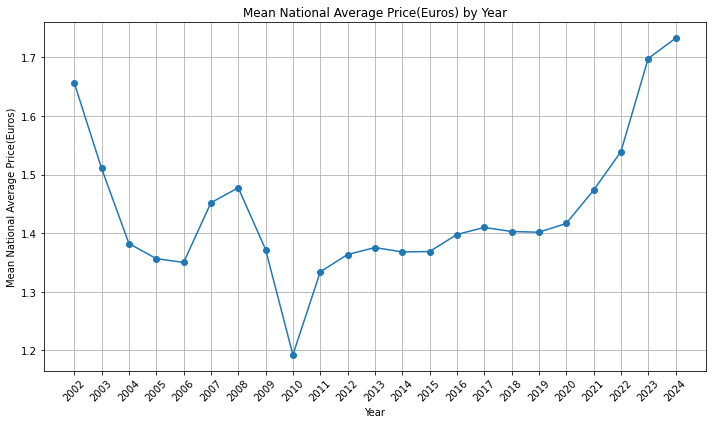

In [63]:
# Convert Spark DataFrame to Pandas DataFrame
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame
result_pandas = result.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(result_pandas['year'].values, result_pandas['mean'].values, marker='o', linestyle='-')
plt.title('Mean National Average Price(Euros) by Year')
plt.xlabel('Year')
plt.ylabel('Mean National Average Price(Euros)')
plt.grid(True)
plt.xticks(result_pandas['year'].unique(), rotation=45)
plt.tight_layout()
plt.show()



In [75]:
# Calculate quartiles
quartiles = merged_df.groupBy("year").agg(expr("percentile_approx(`National Average Price(Euros)`, 0.25)").alias("q1"),
                                           expr("percentile_approx(`National Average Price(Euros)`, 0.75)").alias("q3"))

# Calculate IQR
quartiles = quartiles.withColumn("IQR", quartiles.q3 - quartiles.q1)
quartiles.show()

+----+-----+-----+--------------------+
|year|   q1|   q3|                 IQR|
+----+-----+-----+--------------------+
|2003|1.453|1.513| 0.05999999999999983|
|2007|1.437|1.468|0.030999999999999917|
|2006|1.326|1.348| 0.02200000000000002|
|2004|1.352|1.383|0.030999999999999917|
|2009|1.305|1.534|  0.2290000000000001|
|2005|1.332|1.374| 0.04200000000000004|
|2010|1.111|1.259|  0.1479999999999999|
|2011|1.323| 1.35|0.027000000000000135|
|2008|1.459|1.478|0.018999999999999906|
|2002|1.652|1.691|0.039000000000000146|
|2018|  1.4|1.405|0.005000000000000...|
|2015|1.362| 1.37|0.008000000000000007|
|2023|1.689|1.699|0.010000000000000009|
|2022|1.495| 1.56| 0.06499999999999995|
|2013|1.369|1.377|0.008000000000000007|
|2014|1.362|1.372|0.010000000000000009|
|2019|1.401|1.404|0.002999999999999...|
|2020|1.377|1.463| 0.08600000000000008|
|2012|1.356|1.371|0.014999999999999902|
|2016|1.389|1.405|0.016000000000000014|
+----+-----+-----+--------------------+
only showing top 20 rows



In [ ]:
# from pyspark.sql import functions as F

#Compute skewness
skewness_result = merged_df.agg(F.skewness('National Average Price(Euros)').alias('Skewness'))

#Compute kurtosis
kurtosis_result = merged_df.agg(F.kurtosis('National Average Price(Euros)').alias('Kurtosis'))

#Show results
skewness_result.show()
kurtosis_result.show()


In [55]:
#Histogram
data_driver = {'obs': merged_df.select('National Average Price(Euros)').rdd.flatMap(lambda row: row).collect()}


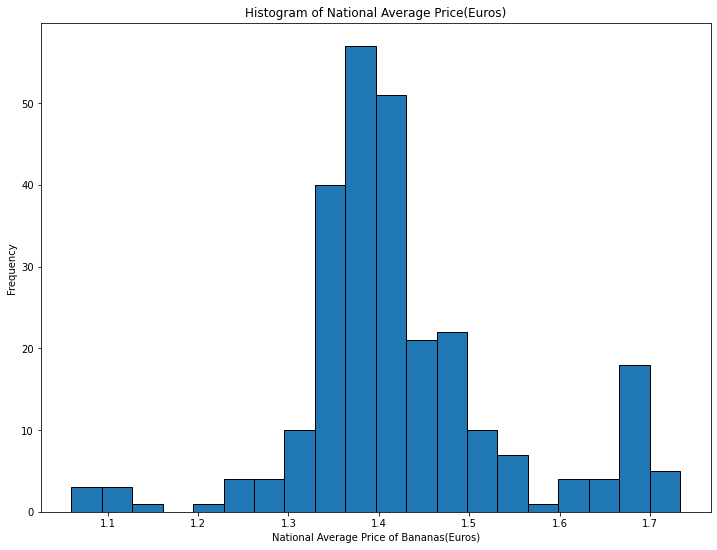

In [56]:
# Histogram
data_driver = {'obs': merged_df.select('National Average Price(Euros)').rdd.flatMap(lambda row: row).collect()}

# Filter out None values from the data
data_filtered = [x for x in data_driver['obs'] if x is not None]

# Create histogram
plt.figure(figsize=(12, 9))
plt.hist(data_filtered, bins=20, edgecolor='black')
plt.title('Histogram of National Average Price(Euros)')
plt.xlabel('National Average Price of Bananas(Euros)')
plt.ylabel('Frequency')

# Save the histogram as an image
plt.savefig('B05793_05_22.png', dpi=300)
plt.show()

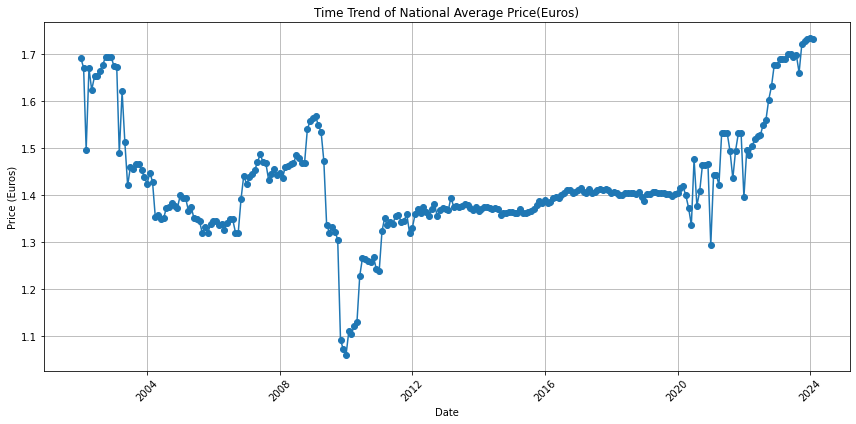

In [57]:
import matplotlib.pyplot as plt

# Collect data to the driver node
dates = merged_df.select('Date').rdd.flatMap(lambda row: row).collect()
prices = merged_df.select('National Average Price(Euros)').rdd.flatMap(lambda row: row).collect()

# Plot the line plot
plt.figure(figsize=(12, 6))
plt.plot(dates, prices, marker='o', linestyle='-')
plt.title('Time Trend of National Average Price(Euros)')
plt.xlabel('Date')
plt.ylabel('Price (Euros)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyspark.sql.functions import year, month
import pyspark.sql.functions as F

# Extract year and month from the Date column
df_with_year_month = merged_df.withColumn("Year", F.year("Date")).withColumn("Month", F.month("Date"))

# Group by Year and Month and calculate the average price for each group
average_prices = df_with_year_month.groupBy("Year", "Month").agg(F.mean("National Average Price(Euros)").alias("AvgPrice"))

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
average_prices_pd = average_prices.toPandas()

# Create subplots
fig = make_subplots(rows=1, cols=1)

# Add traces for each year
for year in average_prices_pd['Year'].unique():
    data_year = average_prices_pd[average_prices_pd['Year'] == year]
    fig.add_trace(go.Scatter(x=data_year['Month'], y=data_year['AvgPrice'],
                             mode='lines',
                             name=str(year)))

# Update layout
fig.update_layout(title='Average National Price Variation Over Months',
                  xaxis_title='Month',
                  yaxis_title='Average National Price (Euros)',
                  xaxis=dict(tickmode='array', tickvals=list(range(1, 13)),
                             ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']),
                  sliders=[{'currentvalue': {'visible': False}, 'steps': [{'args': [[f'{year}'], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}], 'label': year, 'method': 'animate'}] for year in average_prices_pd['Year'].unique()])

# Show plot
fig.show()

## EXPORT THE PREPROCESSED DATA TO HADOOP FOR STORAGE

In [ ]:
# Export preprocessed data
preprocessed_data_path = "hdfs://localhost:9000/preprocessed_data.csv"
cleaned_df.write.csv(preprocessed_data_path, mode="overwrite", header=True)

# Convert the data to pandas

In [79]:
banana_price = merged_df.toPandas()

In [80]:
type(banana_price)

pandas.core.frame.DataFrame

In [81]:
banana_price.head()

,Consumer Item,Date,National Average Price(Euros),year,month
0,Bananas per kg.,2002-01-01,1.691,2002,1
1,Bananas per kg.,2002-02-01,1.670,2002,2
2,Bananas per kg.,2002-03-01,1.496,2002,3
3,Bananas per kg.,2002-04-01,1.669,2002,4
4,Bananas per kg.,2002-05-01,1.623,2002,5


In [82]:
banana_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Consumer Item                  266 non-null    object 
 1   Date                           266 non-null    object 
 2   National Average Price(Euros)  266 non-null    float64
 3   year                           266 non-null    int32  
 4   month                          266 non-null    int32  
dtypes: float64(1), int32(2), object(2)
memory usage: 8.4+ KB


In [83]:
# Save the DataFrame to a CSV file
banana_price.to_csv("/home/hduser/Documents/Advanced-Data-Analytics-and-BIg-Data-Analytics-Project/banana_price.csv", index=False)